![header](header.png)

# Procesamiento Digital de Señales en Sistemas Embebidos

---

# Actividad: Correlación Cruzada
## Introducción
En general, la correlación describe la relación mutua que existe entre dos o más cosas. La misma definición es válida incluso en el caso de las señales. Es decir, la correlación entre señales indica la medida en que la señal dada se parece a otra señal.
Dependiendo de si las señales consideradas para la correlación son iguales o diferentes, tenemos dos tipos de correlación: autocorrelación y correlación cruzada.
En la Autocorrelación la señal dada se correlaciona consigo misma, generalmente la versión de sí misma desplazada en el tiempo. La expresión matemática para la autocorrelación de la señal de tiempo continuo x (t) viene dada por

$$R_{xx}[m] =  \sum_{n=0}^{N-1} x_n.x_{n-m} $$


En el caso de la Correlación Cruzada la señal de interés se correlaciona con otra señal para saber cuánto semejanza existe entre ellos. La expresión matemática para la correlación cruzada de señales de tiempo continuas x (t) e y (t) viene dada por


$$R_{xy}[m] =  \sum_{n=0}^{N-1} x_n.y_{n-m} $$

## Links

__[Producto Punto](https://jackschaedler.github.io/circles-sines-signals/dotproduct.html)__

__[Correlación con Sinusoidales](https://jackschaedler.github.io/circles-sines-signals/dotproduct3.html)__

__[DFT](https://jackschaedler.github.io/circles-sines-signals/dft_walkthrough.html)__

## Ejemplo de Aplicación

La variabilidad del ritmo cardíaco es cuando la cantidad de tiempo entre los latidos del corazón fluctúa ligeramente. Estas variaciones son muy pequeñas, sumando o restando una fracción de segundo entre tiempos.

### Intervalos RR
Nuestro objetivo principal aquí es encontrar una forma sólida de encontrar las ubicaciones exactas de los puntos R en la señal de ECG, también conocida como "detección de pico R". Usando estos puntos podemos obtener las distancias entre esos puntos, los intervalos entre latidos también conocidos como intervalos RR. A veces, estos se denominan intervalos NN para indicar explícitamente los latidos normales.

### Detección de picos mediante coincidencia de plantillas

Hay una miríada de diferentes detectores de QRS. La mayoría de ellos consta de dos etapas:

Etapa 1 — Transformación de la señal
Construya una señal que maximice las características de interés, en nuestro caso, este es el complejo QRS.
Etapa 2 — Regla de decisión
Use un umbral para separar las características deseadas del resto de la señal
Muchos detectores de picos usan un truco muy ingenioso para transformar la señal (etapa 1) y me pareció que valía la pena sumergirse en eso. Se llama coincidencia de plantillas.

La coincidencia de plantillas se usa ampliamente en el reconocimiento de patrones, por ejemplo, en el análisis de partículas, el criptoanálisis, la visión por computadora y la neurociencia computacional. Es una técnica elegante y poderosa que usa un filtro (también conocido como plantilla o kernel), que contiene una característica específica y usa ese filtro para encontrar esta característica en una señal más grande.

In [2]:
'''
https://www.kaggle.com/code/stetelepta/exploring-heart-rate-variability-using-python/notebook
'''

In [2]:
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label 
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

C:\Users\juani\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Carga de datos y graficación

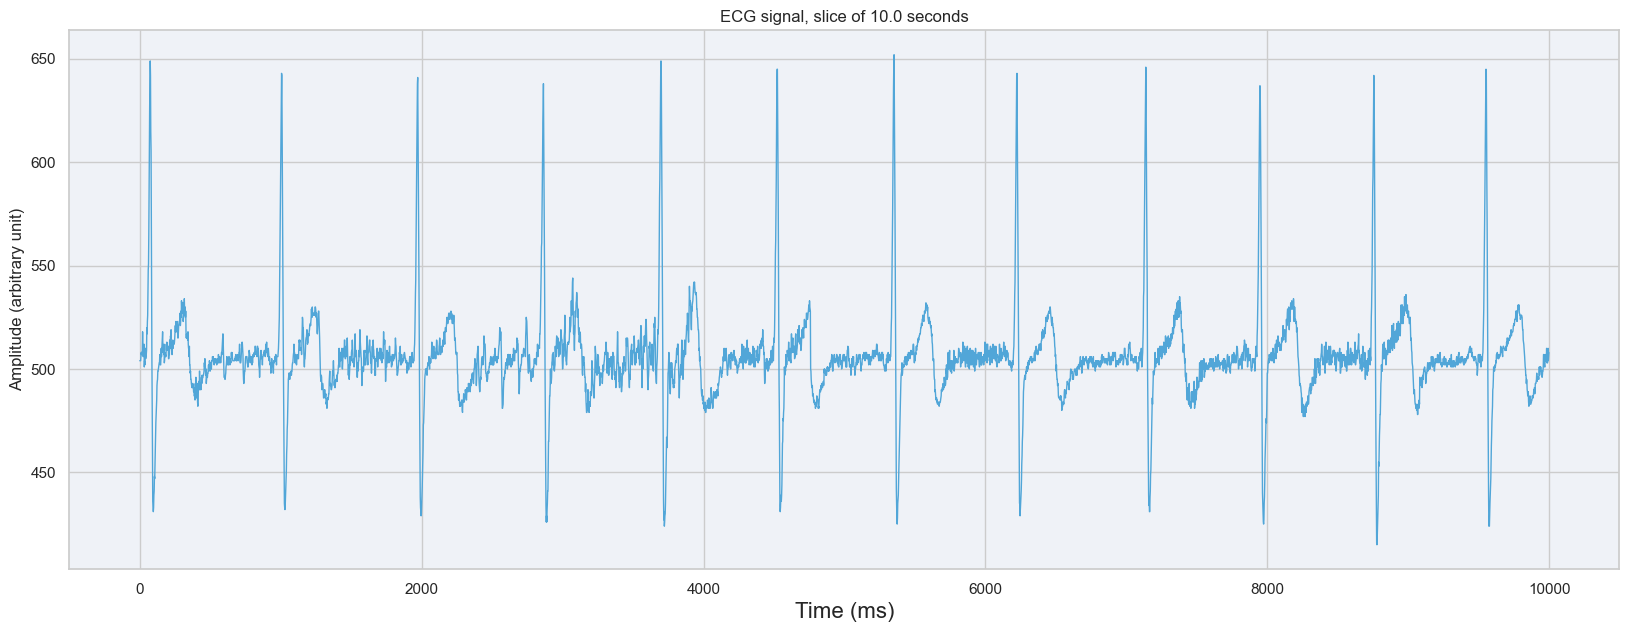

In [4]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500
# data recorded with the ECG sensor
df = pd.read_csv("ecg.csv", sep=";", index_col="ms")
plt.figure(figsize=(20, 7))
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

### Función para la detección de picos

In [5]:
def detect_peaks(ecg_signal, threshold=0.5, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

### Señal del kernel para la correlación

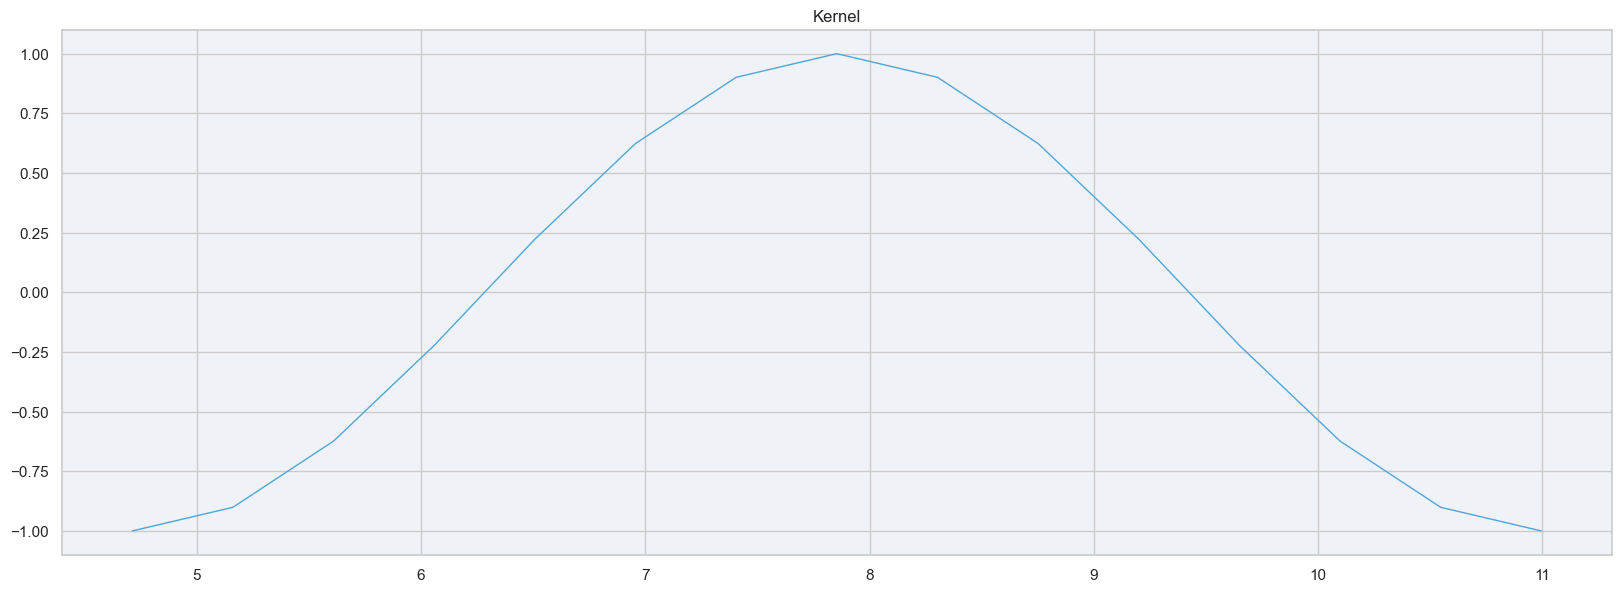

In [10]:
t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
qrs_filter = np.sin(t)
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("Kernel")
plt.plot(t, qrs_filter,  color="#51A6D8", linewidth=1)

### Correlació de las señales y graficación

Text(0, 0.5, 'Similarity (normalized)')

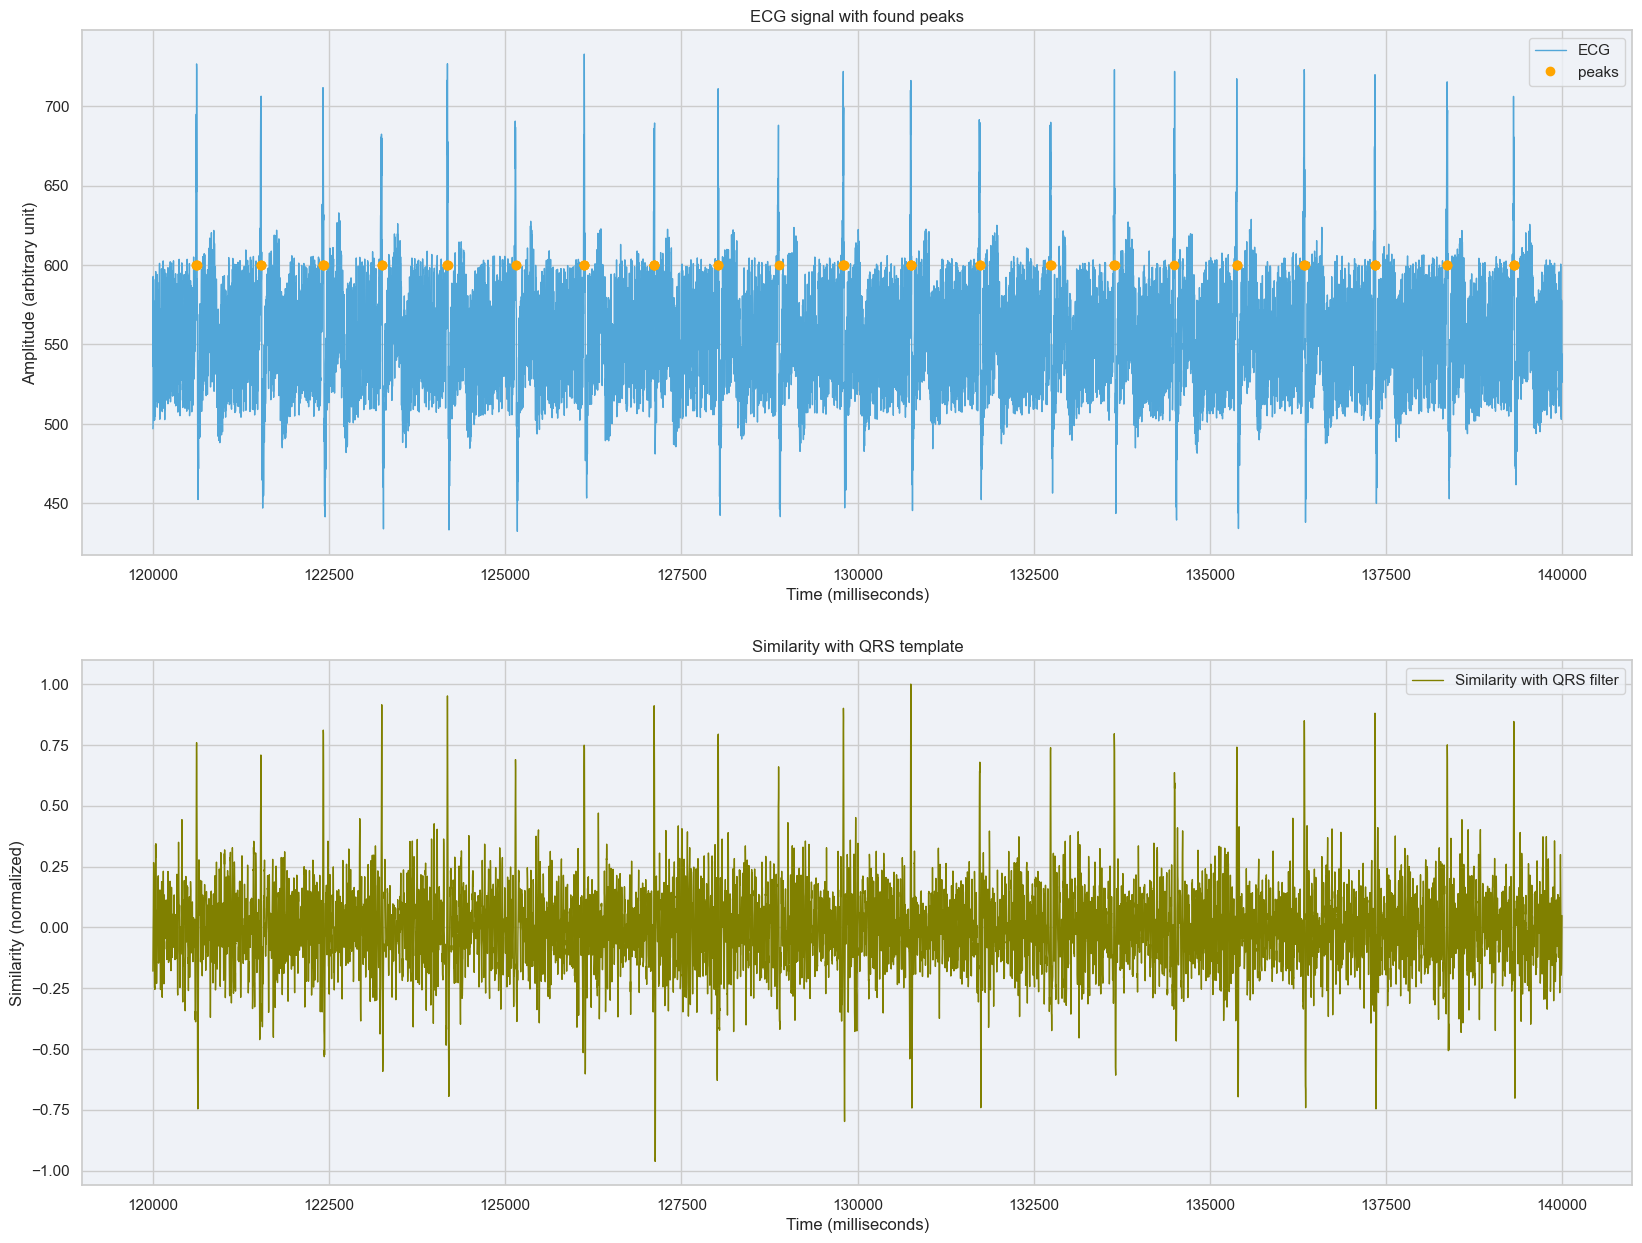

In [8]:
sampfrom = 60000
sampto = 70000
nr_plots = 1
filter = df.heartrate[61100:61500]

ecg_slice = df.heartrate[sampfrom:sampto]+np.random.rand(sampto-sampfrom)*100 #Add noise

    # detect peaks
peaks, similarity = detect_peaks(ecg_slice, threshold=0.6)#, qrs_filter = filter)
   
# plot similarity
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("ECG signal with found peaks")
plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(600, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Amplitude (arbitrary unit)")
    
plt.subplot(212)
plt.title('Similarity with QRS template')
plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
plt.legend(loc="upper right")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Similarity (normalized)")